**Question 2. For the plane frame shown in figure 2, determine the following. Obtain results
at E = 200 GPa, A= 4 x 10-2 m2, I = 1 x 10-6 m4, w = 8 kN/m, L1=2 m, L2=4 m, L3=3 m.**
1. Global stiffness matrix for the structure.
2. Displacements and rotation at node 2.
3. Reactions at nodes 1 and 3.
4. Axial force, shear force, and bending moment in each element.
5. Axial force, shear force, and bending moment diagrams for each element.

In [4]:
#Defining Frame element
import numpy as np
import matplotlib.pyplot as plt

class Node:
    """Node(3 DOF)
        -Num= node id
        -Pos: Coordinate Position
        -Disp: [u1,u2,u3],  (#Generalized disp, for beam u1 is horizontal, u2 is vertical disp and u3 is rotation)
        -Restrained[i]==1 if restrained 0 if unrestrained
        -Load Vector=[P1,P2,P3]        (#Generalized Load)s
        -Association[i]=Structure DOF corresponding to ith local dof
        """
    def __init__(self,num,Pos,Disp=[0.0,0.0,0.0],Restrain=[0,0,0],Load=[0,0,0],Association=[None,None,None]) -> None:
        self.Num=id
        self.Pos=np.asarray(Pos)
        self.Disp_vec=np.asarray(Disp)
        self.restrained=np.asarray(Restrain)
        self.Load=np.asarray(Load)
        self.Association=Association
    def set_Pos(self,Pos):
        self.Pos=Pos
    def get_Pos(self):
        return self.Pos
    def get_ID(self):
        return self.ID
    def get_Disp(self):
        return self.Disp_vec
    def get_disp_pos(self,exxag=1.0):
        prev_pos=self.Pos.reshape(-1,1)
        Disp_vec=self.Disp_vec.reshape(-1,1)
        new_pos=np.add(prev_pos,exxag*Disp_vec)
        return new_pos
    def set_Disp(self,Disp):
        self.Disp_vec=np.asarray(Disp)
    def get_Load(self):
        return self.Load
    def get_restrains(self):
        return self.restrained
    def set_Load(self,Load=[0,0,0]):
        assert len(Load)==3
        self.Load=np.asarray(Load)
    def set_Restr(self,Restrain=[0,0,0]):
        assert len(Restrain)==3
        self.restrained=np.asarray(Restrain)
    def get_Association(self):
        res=[]
        res=self.Association.copy()
        return res
    def set_Association(self,Association :list):
        assert len(Association)==3
        self.Association=Association
    

class Frame_element:
    """Bar Element
        -E,I,A,L
        -k_local=p[[A     0      0     -A      0       0]
                    [0  12I/L2  6I/L    0   -12I/L2 6I/L]
                    [0  6I/L    4I      0   -6I/L   2I]
                    [-A   0      0      A       0    0  ]
                    [0  -12I/L2 -6I/L   0   12I/L2 -6I/L]
                    [0  6I/L    2I      0   -6I/L   4I  ]]
        p=E/L
        -Theta (in degrees) from global axes
       
        """
    def __init__(self,N1:Node,N2 :Node,E=1,A=1,I=1) -> None:
        self.L=np.linalg.norm(np.add(N2.get_Pos(),-1*N1.get_Pos()))
        self.N1=N1
        self.N2=N2
        self.E=E
        self.A=A
        self.I=I
        self.UDL=0  #Currently only perp UDL supported 
        self.K=E*A/self.L
        if(np.add(N2.get_Pos(),-1*N1.get_Pos())[0]==0.0):
            if(np.add(N2.get_Pos(),-1*N1.get_Pos())[1]>0):
                self.Theta=90.0
            else:
                self.Theta=-90.0
        else:
            self.Theta=np.arctan(np.add(N2.get_Pos(),-1*N1.get_Pos())[1]/np.add(N2.get_Pos(),-1*N1.get_Pos())[0])*180/np.pi
        self.Fix_F=np.zeros((6,1))
    def get_local_k(self):
        #Returns local stiffness matrix [2x2]
        p=self.E/self.L
        l=self.L
        i=self.I
        a=self.A
        return p*np.asarray([[a,0,0,-1*a,0,0],[0,12*i/(l*l),6*i/l,0,-12*i/(l*l),6*i/l],[0,6*i/l,4*i,0,-6*i/l,2*i],[-1*a,0,0,a,0,0],[0,-12*i/(l*l), -6*i/l,0,12*i/(l*l), -6*i/l],[0,6*i/l,2*i,0,-6*i/l,4*i]])
    
    def get_global_k(self):
        #Return global stiffness matrix =[T]'*[K_Local]*[T]
        T=self.get_T()
        K_Local=self.get_local_k()
        return np.dot(np.dot(T.T,K_Local),T)
    
    def get_T(self):
        #Transformation matrix
        if(self.Theta==90.0):
            c=0.0
            s=1.0
        else:
            c=np.cos(self.Theta*np.pi/180)
            s=np.sin(self.Theta*np.pi/180)
        T :np.ndarray=np.asarray([[c,s,0,0,0,0],[-1*s,c,0,0,0,0],[0,0,1,0,0,0],[0,0,0,c,s,0],[0,0,0,-1*s,c,0],[0,0,0,0,0,1]])
        return T

    def get_disp(self):
        return np.concatenate((self.N1.get_Disp(),self.N2.get_Disp()))
    
    def get_force(self):
        return np.concatenate((self.N1.get_Load(),self.N2.get_Load()))
    def set_UDL(self,w :float):
        self.UDL=w
        V=w*self.L/2
        M=w*(self.L**2)/12
        #Return global stiffness matrix =[T]'*[K_Local]*[T]
        T=self.get_T()
        self.Fix_F=np.asarray([[0],[-1*V],[-1*M],[0],[-1*V],[M]]) #To be added for member stresses
        #Convert UDL to nodal load
        Load=np.dot(T,self.Fix_F)
        self.N1.set_Load(Load[0:3])
        self.N2.set_Load(Load[3:])

    def set_E(self,E):
        self.E=E
    def set_A(self,A):
        self.A=A
    def set_I(self,I):
        self.I=I
    def get_E(self):
        return self.E
    def get_I(self):
        return self.I
    def get_Nodes(self):
        return [self.N1,self.N2]
    def get_Association(self):
        return self.N1.get_Association()+self.N2.get_Association()
    def get_element_stress(self):
        """To get [Axial1 Shear1 Moment1 Axial2 Shear2 Moment2] at ends of beam(with FEM sign convention, i.e along chosen disp direction)"""
        U=self.get_disp()
        #Convert to local coodrinates
        T=self.get_T()
        U_local=np.dot(T,U)
        F_disp=np.dot(self.get_local_k(),U_local)
        
        if(self.UDL==0):
            return F_disp
        else:
            return F_disp-self.Fix_F
    
    def plot_AFD(self,ax :plt.Axes,scale=1.0):
        Force_vec=self.get_element_stress()
        H1=Force_vec[0]
        H2=-1*Force_vec[3]
        bins=100

        #plot member
        x1,y1=self.N1.get_Pos()[0],self.N1.get_Pos()[1]
        x2,y2=self.N2.get_Pos()[0],self.N2.get_Pos()[1]
        ax.plot([x1,x2],[y1,y2],color='k')
        ax.scatter([x1,x2],[y1,y2],color='k')

        x=np.linspace(0,self.L,bins)
        y=[H1-self.UDL*i for i in x]
        #shifting and rotating
        c=np.cos(self.Theta*np.pi/180)
        s=np.sin(self.Theta*np.pi/180)
        for i in range(len(x)):
            x0=x[i]
            y0=y[i]*scale
            x[i]=x1+x0*c-y0*s
            y[i]=y1+x0*s+y0*c
        ax.plot(x,y,color='b')
        ax.plot([x1,x[0]],[y1,y[0]],color='b',linestyle='--')
        ax.plot([x2,x[len(x)-1]],[y2,y[len(y)-1]],color='b',linestyle='--')
        
        return ax
    def plot_SFD(self,ax :plt.Axes,scale=1.0):
        Force_vec=self.get_element_stress()
        V1=Force_vec[1]
        V2=-1*Force_vec[4]
        bins=100

        #plot member
        x1,y1=self.N1.get_Pos()[0],self.N1.get_Pos()[1]
        x2,y2=self.N2.get_Pos()[0],self.N2.get_Pos()[1]
        ax.plot([x1,x2],[y1,y2],color='k')
        ax.scatter([x1,x2],[y1,y2],color='k')
        x=np.linspace(0,self.L,bins)
        y=[V1-self.UDL*i for i in x]
        #shifting and rotating
        c=np.cos(self.Theta*np.pi/180)
        s=np.sin(self.Theta*np.pi/180)
        for i in range(len(x)):
            x0=x[i]
            y0=y[i]*scale
            x[i]=x1+x0*c-y0*s
            y[i]=y1+x0*s+y0*c
        ax.plot(x,y,color='b')
        ax.plot([x1,x[0]],[y1,y[0]],color='b',linestyle='--')
        ax.plot([x2,x[len(x)-1]],[y2,y[len(y)-1]],color='b',linestyle='--')
        
        return ax

    def plot_BMD(self,ax :plt.Axes,scale=1):
        """Assumes no concentrated force within span"""
        Force_vec=self.get_element_stress()
        M1=-1*Force_vec[2]
        V1=Force_vec[1]
        bins=100
        #plot member
        x1,y1=self.N1.get_Pos()[0],self.N1.get_Pos()[1]
        x2,y2=self.N2.get_Pos()[0],self.N2.get_Pos()[1]
        ax.plot([x1,x2],[y1,y2],color='k')
        ax.scatter([x1,x2],[y1,y2],color='k')
        x=np.linspace(0,self.L,bins)
        y=[M1+V1*i-self.UDL*i*i/2 for i in x]
        #shifting and rotating
        c=np.cos(self.Theta*np.pi/180)
        s=np.sin(self.Theta*np.pi/180)
        for i in range(len(x)):
            x0=x[i]
            y0=y[i]*scale
            x[i]=x1+x0*c-y0*s
            y[i]=y1+x0*s+y0*c
        ax.plot(x,y,color='b')
        ax.plot([x1,x[0]],[y1,y[0]],color='b',linestyle='--')
        ax.plot([x2,x[len(x)-1]],[y2,y[len(y)-1]],color='b',linestyle='--')
        
        return ax

In [5]:
#Q1 solution here 

#units= kN-m

#Step1: Define the Node coordinates, and elements as set of two nodes
Nod_cord=[(0,3),(2,0),(6,0)]       
Elements=[(1,2),(2,3)]

#Step2: Create Nodes and elements(Auto)
Nodes=dict()
Elem=dict()
for i in range(len(Nod_cord)):
    Nodes[i+1]=Node(i+1,[Nod_cord[i][0],Nod_cord[i][1]])

#Step3: Apply Loads and Restraints(Manual)
Nodes[1].set_Restr([1,1,1])   #1 for restrained, 0 for unrestrained [Ux_restr,Uy_restr]
Nodes[3].set_Restr([1,1,1])

#Assign properties to elements(E,A,I)
for i in range(len(Elements)):
    N1=Elements[i][0]
    N2=Elements[i][1]
    Elem[i+1]=Frame_element(Nodes[N1],Nodes[N2],E=2e8,A=4e-2,I=1e-6)

#Apply UDL at element 2
Elem[2].set_UDL(8)

#Step 4: Node numbering with structural dofs, forming association matrices
Count_P=0
DOF_counter=0
    #First number unrestrained DOF
for i in Nodes.keys():
    #Take node
    node :Node=Nodes[i]
    restr=node.get_restrains()
    #Check its restraints , restr[j]==0 implies unrestrained, restr[j]==1 implies restrained
    #restr=node.get_Restr()
    Associate=node.get_Association()
    for j in range(len(restr)):
        if(restr[j]==0):
            Associate[j]=DOF_counter
            Count_P+=1
            DOF_counter+=1
    node.set_Association(Associate)

    #Now number restrained joints
for i in Nodes.keys():
    #Take node
    node :Node=Nodes[i]
    #Check its restraints
    restr1=Nodes[i].get_restrains()
    Associate=node.get_Association()
    for j in range(len(restr1)):
        if(restr1[j]==1):
            Associate[j]=DOF_counter
            DOF_counter+=1
    node.set_Association(Associate)


#Step 5: ASSEMBLING
    #Global stiffness maTriX [K_total] (2n x 2n), [Force Vector](nx1) and [Displacement Vector](nx1)
N=3*len(Nodes)
P=Count_P            #No. of Unrestrained joints for KPP :P x P
K_Ts=np.zeros((N,N)) #Total stiffness matrix
for i in Elem.keys():
    member :Frame_element=Elem[i]
    Association=member.get_Association()
    k_g=member.get_global_k()
    K_Ts[np.ix_(Association,Association)]=np.add(K_Ts[np.ix_(Association,Association)],k_g)

print(K_Ts*1e-3)


[[ 2.68274338e+03 -1.02403827e+03 -7.68046426e-02 -6.82743382e+02
   1.02403827e+03 -7.68046426e-02 -2.00000000e+03  0.00000000e+00
   0.00000000e+00]
 [-1.02403827e+03  1.53614611e+03  2.37969050e-02  1.02403827e+03
  -1.53610861e+03 -5.12030950e-02  0.00000000e+00 -3.75000000e-02
   7.50000000e-02]
 [-7.68046426e-02  2.37969050e-02  4.21880078e-01  7.68046426e-02
   5.12030950e-02  1.10940039e-01  0.00000000e+00 -7.50000000e-02
   1.00000000e-01]
 [-6.82743382e+02  1.02403827e+03  7.68046426e-02  6.82743382e+02
  -1.02403827e+03  7.68046426e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.02403827e+03 -1.53610861e+03  5.12030950e-02 -1.02403827e+03
   1.53610861e+03  5.12030950e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.68046426e-02 -5.12030950e-02  1.10940039e-01  7.68046426e-02
   5.12030950e-02  2.21880078e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.00000000e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.0000000

In [6]:
F=np.zeros((N,1))    #Nodal Force vector
U=np.zeros((N,1))    #Nodal Displacement Vector
for i in Nodes.keys():
    node :Node =Nodes[i]
    Association=node.get_Association()
    node_disp=node.get_Disp().reshape(-1,1)
    node_force=node.get_Load().reshape(-1,1)
    F[Association]=node_force
    U[Association]=node_disp

#Step 6: Partition [K_total] into Kpp,Kpx,Kxp,Kxx and [U] into Up,Ux, and [F] into Fp,Fx

Kpp=K_Ts[:P,:P]
Kpx=K_Ts[:P,P:]
Kxp=K_Ts[P:,:P]
Kxx=K_Ts[P:,P:]

Fp=F[:P]
Fx=F[P:]
Up=U[:P]
Ux=U[P:]

#Step 7: Solve the F-D relation equations
"""Solving force-displacement equations
    [Kpp]{Up}+[Kpx]{Ux}={Fp}
    [Kxp]{Up}+[Kxx]{Ux}={Fx}

    {Up}=[Kpp]^(-1){[Fp]-[Kpx][Ux]}     #Unknown forces 
    {Fx}=[Kxp]{Up}+[Kxx]{Ux}            #Unknown Reactions
"""

Up=np.dot(np.linalg.inv(Kpp),np.add(Fp,-1*np.dot(Kpx,Ux)))
Fx=np.add(np.dot(Kxp,Up),np.dot(Kxx,Ux))
U=np.concatenate((Up,Ux))
F=np.concatenate((Fp,Fx))

#Step 8: UPDATING NODAL VALUES with outputs
for i in Nodes.keys():
    node :Node =Nodes[i]
    Association=node.get_Association()
    node.set_Disp(U[Association])
    node.set_Load(F[Association])
    

#Step 9 :Print Results
print("Nodal Results")
print("\nNode\tUx(mm)\t\tUy(mm)\t\tTheta(Deg)\tFx(kN)\t\tFy(kN)\t\tM(kNm)")
for i in Nodes.keys():
    node :Node =Nodes[i]
    Disp_node=node.get_Disp()
    Disp_force=node.get_Load()
    print(i,"\t%8.7f\t %8.7f\t %8.7f\t %8.7f\t %8.7f\t %8.7f"%(Disp_node[0][0]*1000,Disp_node[1][0]*1000,Disp_node[2][0],Disp_force[0][0],Disp_force[1][0],Disp_force[2][0]))


#Step 10 :Shear and bending moment in eash element
print("\nElement Results")
print("\nElement\tH1(kN)\t\tV1(kN)\t\tM1(kN.m)\tH2(kN)\t\tV2(kN)\t\tM2(kN.m)")
for i in Elem.keys():
    member :Frame_element=Elem[i]
    Member_force_vec=member.get_element_stress()
    print(i,"\t%8.7f\t %8.7f\t %8.7f\t %8.7f\t %8.7f\t %8.7f"%(Member_force_vec[0],Member_force_vec[1],Member_force_vec[2],Member_force_vec[3],Member_force_vec[4],Member_force_vec[5]))


Nodal Results

Node	Ux(mm)		Uy(mm)		Theta(Deg)	Fx(kN)		Fy(kN)		M(kNm)
1 	0.0000000	 0.0000000	 0.0000000	 -12.2063265	 14.1031743	 -2.8038135
2 	-0.0061032	 -0.0140925	 -0.0252840	 0.0000000	 -16.0000000	 -10.6666667
3 	0.0000000	 0.0000000	 0.0000000	 12.2063265	 1.8968257	 -2.5294532

Element Results

Element	H1(kN)		V1(kN)		M1(kN.m)	H2(kN)		V2(kN)		M2(kN.m)
1 	-18.5054020	 -2.3332439	 -2.8038135	 18.5054020	 2.3332439	 -5.6088172
2 	-12.2063265	 14.1031743	 5.6088172	 12.2063265	 17.8968257	 -13.1961199


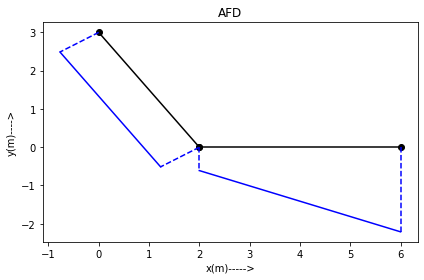

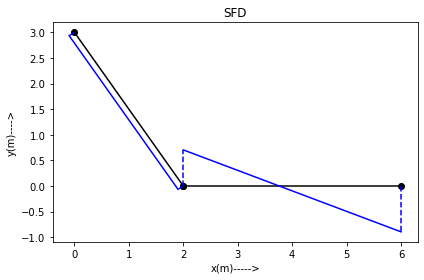

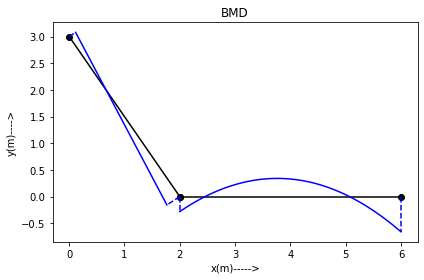

In [7]:
import matplotlib.pyplot as plt

#Plot AFD
N=len(Elem.keys())
fig,ax=plt.subplots(1,1)
for i in Elem.keys():
    member :Frame_element=Elem[i]
    member.plot_AFD(ax,scale=0.05)
ax.set_title("AFD")
ax.set_xlabel("x(m)----->")
ax.set_ylabel("y(m)---->")
plt.tight_layout()
plt.show()


#Plot SFD
N=len(Elem.keys())
fig,ax=plt.subplots(1,1)
for i in Elem.keys():
    member :Frame_element=Elem[i]
    member.plot_SFD(ax,scale=0.05)
ax.set_title("SFD")
ax.set_xlabel("x(m)----->")
ax.set_ylabel("y(m)---->")
plt.tight_layout()

plt.show()
#Plot BMD
fig,ax=plt.subplots(1,1)
for i in Elem.keys():
    member :Frame_element=Elem[i]
    member.plot_BMD(ax,scale=0.05)
ax.set_title("BMD")
ax.set_xlabel("x(m)----->")
ax.set_ylabel("y(m)---->")

plt.tight_layout()
plt.show()